#### Random Forest Model Optimised
- Uses ensemble of decision trees.
- Breaking whole bunch of decision trees and putting them together.
- Increases prediction accuracy  
PRO   
- Reduces over fitting - which may not be representative of true population
- Reduces Bias - i.e. not evenly split in training.

The number of estimators - number of decision trees used to build the ensemble model. 
In order for the sampling techniques to work best, you should previously perform any pre-processing steps you can. 

### Part 1.  Import Dependancies 

In [43]:
# Basic Imports
import os
import warnings

# Data Manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import seaborn as sns

# Model Building and Evaluation
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, average_precision_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Imbalanced Data Handling
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

# Data File Management
from pathlib import Path

# Jupyter Notebook Inline Plotting
%matplotlib inline

# Suppress Deprecation Warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)


Read in CSV - Test with Option 2 for Sampling Data

In [44]:
####### OPTION 1 if NOT SAMPLING DATA
#################################################
# READ IN CSV fraud_det_dig_df
fraud_df = pd.read_csv("../5.Resources/fraud_det_dig_df.csv")

In [45]:
# ######## OPTION 2 for SAMPLING DATA
########################################################
# ## Create additional step if SAMPLING only.
# ## READ IN CSV fraud_det_dig_df
# fraud_det_df = pd.read_csv("../Resources/fraud_det_dig_df.csv")
# fraud_det_df.head()

# ## Create Sample of data to work with
# # Determine the proportions of 'isFraud' values in the DataFrame
# fraud_proportions = fraud_det_df['isFraud'].value_counts(normalize=True)

# # Calculate the number of samples needed for each 'isFraud' value
# sample_size = 100000
# sample_per_is_fraud = (fraud_proportions * sample_size).astype(int)

# # Use the 'groupby' function to take a proportional sample
# fraud_df = fraud_det_df.groupby('isFraud').apply(lambda x: x.sample(sample_per_is_fraud[x.name]))

# # Reset the index of the sampled DataFrame
# fraud_df.reset_index(drop=True, inplace=True)
# fraud_df.head()

### Part 2. Set Up Model Parameters

In [46]:
# Define target vector and features
y = fraud_df['isFraud'].values.reshape(-1, 1)

# iterations of the model identified to drop the following features
X = fraud_df.drop(['isFraud','isFlaggedFraud','large_transaction','newbalanceOrig','week','bal_change_per'], axis=1)


In [47]:
# Perform train-test split on the original DataFrame
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [48]:
sample_data = fraud_df.drop(['isFlaggedFraud','large_transaction','newbalanceOrig','week','bal_change_per'], axis=1)

# Assuming your DataFrame is named 'df'
fraudulent_transactions = sample_data[sample_data['isFraud'] == 1]

In [49]:
fraudulent_transactions.head(10)


,step,amount,oldbalanceOrg,oldbalanceDest,newbalanceDest,isFraud,hour,day,trans_weight,type_CASH_OUT,type_TRANSFER,Destination
0,1,181.00,181.00,0.0,0.00,1,1,1,1.0,False,True,0
1,1,181.00,181.00,21182.0,0.00,1,1,1,1.0,True,False,1
123,1,2806.00,2806.00,0.0,0.00,1,1,1,1.0,False,True,66
124,1,2806.00,2806.00,26202.0,0.00,1,1,1,1.0,True,False,67
192,1,20128.00,20128.00,0.0,0.00,1,1,1,1.0,False,True,81
193,1,20128.00,20128.00,6268.0,12145.85,1,1,1,1.0,True,False,82
222,1,416001.33,416001.33,102.0,9291619.62,1,1,1,1.0,True,False,91
324,1,1277212.77,1277212.77,0.0,0.00,1,1,1,1.0,False,True,110
325,1,1277212.77,1277212.77,0.0,2444985.19,1,1,1,1.0,True,False,111
346,1,35063.63,35063.63,0.0,0.00,1,1,1,1.0,False,True,117


In [50]:
# Scaling Data using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


# UNDERSAMPLING using RandomUndersampler
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train_scaled, y_train.ravel())

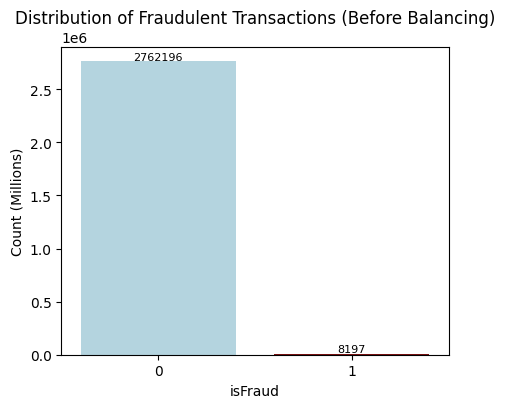

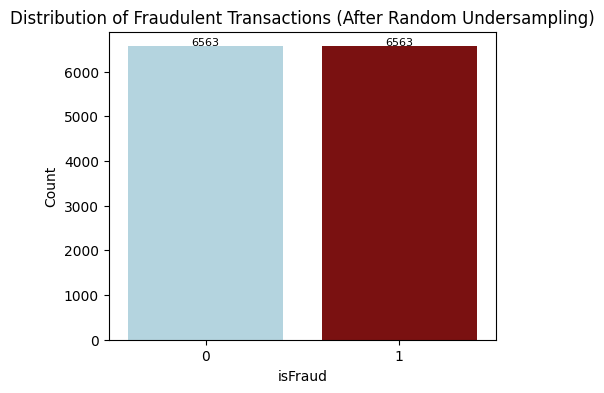

In [51]:
# Visualize the distribution of 'isFraud' before balancing
plt.figure(figsize=(5, 4))
ax = sns.countplot(data=fraud_df, x='isFraud', palette={0: 'lightblue', 1: 'darkred'})

for p in ax.patches:
    count = p.get_height()
    ax.annotate(f"{count:.0f}", (p.get_x() + p.get_width() / 2., count),
                ha='center', va='center', fontsize=8, color='black', xytext=(0, 3), textcoords='offset points')

plt.title("Distribution of Fraudulent Transactions (Before Balancing)")
plt.xlabel("isFraud")
plt.ylabel("Count (Millions)")
plt.show()

# Visualize the distribution of 'isFraud' after Random Undersampling
plt.figure(figsize=(5, 4))
ax = sns.countplot(x=y_rus, palette={0: 'lightblue', 1: 'darkred'})

for p in ax.patches:
    count = p.get_height()
    ax.annotate(f"{count:.0f}", (p.get_x() + p.get_width() / 2., count),
                ha='center', va='center', fontsize=8, color='black', xytext=(0, 3), textcoords='offset points')

plt.title("Distribution of Fraudulent Transactions (After Random Undersampling)")
plt.xlabel("isFraud")
plt.ylabel("Count")
plt.show()


------------------------------------------
### Part 3.  Fitting the Random Forest Model
-----------------------------------------------

In [52]:
# Create a random forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=78)

In [53]:
# Fit the model on the resampled data
rf_model.fit(X_rus, y_rus)

RandomForestClassifier(random_state=78)

Making Preductions Using Random Forest Model

In [54]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

Model Evaluation 

In [55]:
# Calculating the confusion matrix
cm = confusion_matrix(y_test, predictions)

cm_df = pd.DataFrame(
    cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"]
)
cm

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

## create Classification Report as a dataframe
report_dict = classification_report(y_test, predictions, output_dict=True)
classification_report_df = pd.DataFrame(report_dict).transpose()

In [56]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("--------------------")
print("Classification Report")
classification_report_df

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,538743,13702
Actual 1,72,1562


Accuracy Score : 0.9751407290296149
--------------------
Classification Report


,precision,recall,f1-score,support
0,0.999866,0.975198,0.987378,552445.000000
1,0.102332,0.955936,0.184874,1634.000000
accuracy,0.975141,0.975141,0.975141,0.975141
macro avg,0.551099,0.965567,0.586126,554079.000000
weighted avg,0.997220,0.975141,0.985011,554079.000000


In [57]:
# Print Model evaluation to CSV for Tableau
cm_df.to_csv('../5.Resources/confusion_matrix.csv', index=False)
classification_report_df.to_csv('../5.Resources/classification_report.csv')

#### Feature Importance

In [58]:
# Get the feature importance array
importances = rf_model.feature_importances_
# List the top 10 most important features
importances_sorted = sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)
importances_sorted[:10]

[(0.17709597780553932, 'newbalanceDest'),
 (0.1685805561400005, 'trans_weight'),
 (0.1626820038689324, 'oldbalanceDest'),
 (0.09960018055667758, 'hour'),
 (0.09819667349974186, 'oldbalanceOrg'),
 (0.0786687380009652, 'step'),
 (0.06520877192645201, 'day'),
 (0.06322073291664293, 'amount'),
 (0.03159495744514184, 'type_CASH_OUT'),
 (0.029409233876555793, 'Destination')]

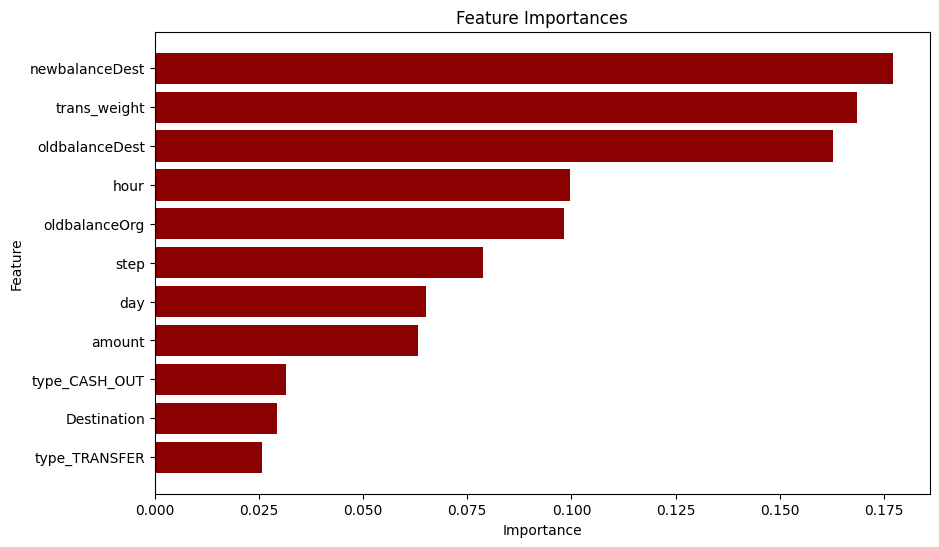

In [59]:
# Create a DataFrame with feature importances
importances_df = pd.DataFrame({'Feature': X.columns, 'Importance': rf_model.feature_importances_})

# Sort the DataFrame by importance values in ascending order to rank features from top to bottom
importances_sorted = importances_df.sort_values(by='Importance')

# Plot the feature importances with dark red color scheme
plt.figure(figsize=(10, 6))
plt.barh(importances_sorted['Feature'], importances_sorted['Importance'], color='darkred')
plt.title('Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [60]:
importances_sorted

,Feature,Importance
9,type_TRANSFER,0.025742
10,Destination,0.029409
8,type_CASH_OUT,0.031595
1,amount,0.063221
6,day,0.065209
0,step,0.078669
2,oldbalanceOrg,0.098197
5,hour,0.099600
3,oldbalanceDest,0.162682
7,trans_weight,0.168581


In [61]:
# ##Convert importances_sorted to a DataFrame then print for Tableau
# Save the DataFrame to a CSV file
importances_sorted.to_csv('../5.Resources/importance_sorted.csv', index=False)

#### Optimisation of Model
Finding the optimal n_estimators - iteration identified 100

In [62]:
###################################
###### 100 identified as optimal n_estimators
###################################
# Define target vector and features
y = fraud_df['isFraud'].values.reshape(-1, 1)
X = fraud_df.drop('isFraud', axis=1)

# Perform train-test split on the original DataFrame
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling Data using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# UNDERSAMPLING using RandomUndersampler
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train_scaled, y_train.ravel())

# Define a range of values for n_estimators to search over
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500]
}

# Create a random forest classifier
rf_model = RandomForestClassifier(random_state=78)

# Perform GridSearchCV with 5-fold cross-validation to find the best n_estimators value
grid_search = GridSearchCV(rf_model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_rus, y_rus)

# Get the best n_estimators value from the grid search results
best_n_estimators = grid_search.best_params_['n_estimators']
print("Best n_estimators:", best_n_estimators)

# Train the model with the best n_estimators value on the full training set
best_rf_model = RandomForestClassifier(n_estimators=best_n_estimators, random_state=78)
best_rf_model.fit(X_rus, y_rus)

# Making predictions using the testing data
predictions = best_rf_model.predict(X_test_scaled)

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)
print("Accuracy Score:", acc_score)

Best n_estimators: 100
Accuracy Score: 0.9749169342277906


Save model file 

In [64]:
############################
## Save Model into in 3. Application Directory 
############################
# Assuming rf_model is your trained model
model = rf_model

# Specify the directory path
directory = "../3. Application"

# Create the directory if it doesn't exist
if not os.path.exists(directory):
    os.makedirs(directory)

# Specify the filename for the pickle file
filename = os.path.join(directory, 'model.pkl')

# Save the model to the pickle file
with open(filename, 'wb') as file:
    pickle.dump(model, file)